In [1]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pytensor.tensor as at
import pytensor
floatX = pytensor.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

In [2]:
# r = te.loada('../../models/Antimony/TopologyC_1_flat.ant')
ant = '../../models/Antimony/TopologyC_1_flat_replaced.ant'
r = te.loada('../../models/Antimony/TopologyC_1_flat_replaced.ant')
r.conservedMoietyAnalysis = True
r.steadyState()

1.1827489929340788e-13

In [3]:
enzyme_names = [i for i in r.getGlobalParameterIds() if 'e_' in i]
assert r.getNumReactions() == len(enzyme_names)

In [4]:
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

CC_results = []
for i,e in enumerate(enzyme_names):
    try: 
        CC_results.append(r.getCC('v_ACE_OUT', e))
    except: 
        CC_results.append((i,e))
        r = te.loada(ant)
        r.conservedMoietyAnalysis = True
        r.steadyState()
        
CC_results

[-0.003101175501044489,
 -0.00025853288378359395,
 -0.0007760528854635039,
 -0.00014092779845948695,
 0.022016093705827994,
 2.889026312178013e-07,
 0.00022964386843127456,
 0.000695962013710848,
 0.038374601419276524,
 -0.027547499681177427,
 -2.6612905278879853e-05,
 -0.014737826792308836,
 0.0002678043310276114,
 -0.001225825799241048,
 0.0005561599066374046,
 0.0004337288616257748,
 -0.00012478458522649944,
 -0.0005099560311931176,
 -0.010389714317036619,
 3.7899843774360424e-05,
 0.0054679627413395816,
 0.028541509890570187,
 -5.4628292236684377e-08,
 0.009091990724178699,
 0.005689479768795764,
 -0.9543826060858633,
 -0.0002153474906998139,
 -0.0001848283095952875,
 -0.005218693335476647,
 0.027894716332582004,
 2.0439425863169705e-06,
 0.005597418302773105,
 1.3943390432372107e-05,
 0.022984937321216835,
 -0.02064016851780062,
 0.01068122153528761,
 0.0013008824558716227,
 0.0050405304209301385,
 -0.004482136742983562,
 0.016061631712593557,
 0.0013463501148123598,
 -0.058223751

In [5]:
# these indices return errors when running getCC

CC_results[44] = 0
CC_results[62] = 0

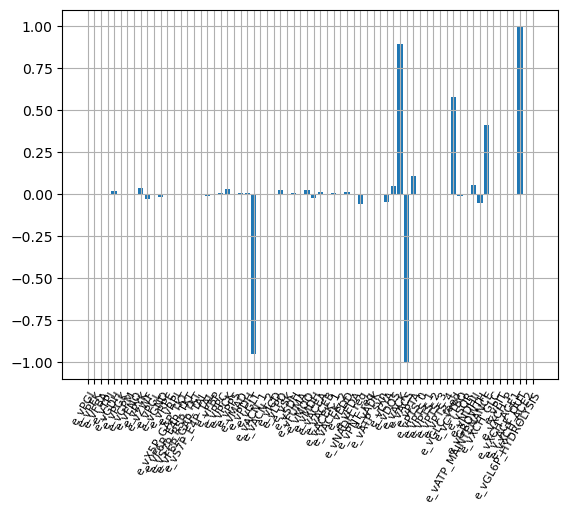

In [6]:
fig = plt.bar(enzyme_names, CC_results)
plt.xticks(rotation=60, ha='right', rotation_mode='anchor', fontsize=8);
plt.grid()

In [9]:
pd.DataFrame(r.getScaledFluxControlCoefficientMatrix()[65], index=r.getReactionIds()).sort_values(0)

0
vACS             -1.002356
vGLT             -0.954383
vATP_syn         -0.130608
vNADH_req        -0.058224
vGROWTH          -0.052748
...                    ...
vPTA              0.109178
vATP_MAINTENANCE  0.410452
vGLC_feed         0.580473
vACK              0.897560
v_ACE_OUT         0.999988

[68 rows x 1 columns]

In [9]:
# where are the magnitudes of the CCs larger than 0.1?
large_idx = np.where(abs(np.array(CC_results)) > 0.1)[0]

for i in large_idx: 
    print(enzyme_names[i], str(round(CC_results[i], 5)))

e_vGLT -0.95438
e_vACK 0.89756
e_vACS -1.00236
e_vPTA 0.10918
e_vGLC_feed 0.58047
e_vATP_MAINTENANCE 0.41045
e_v_ACE_OUT 0.99999


### Do the CCs add to 1?

In [10]:
np.sum(np.array(CC_results))

1.0893616132391248

### The problem reactions and their error messages

In [19]:
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# r.getCC('v_ACE_OUT', 'e_vATP_syn')
jref = r.v_ACE_OUT
r.e_vATP_syn = r.e_vATP_syn * 1.05
r.steadyState()
jnew = r.v_ACE_OUT

ccpit = ((jnew - jref)/(jref)) / (.05)
ccpit

-0.128722613734141

In [20]:
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# r.getCC('v_ACE_OUT', 'e_vPIT')
jref = r.v_ACE_OUT
r.e_vPIT = r.e_vPIT * 1.05
r.steadyState()
jnew = r.v_ACE_OUT

ccpit = ((jnew - jref)/(jref)) / (.05)
ccpit

0.03916668037485254

### Large elasticity values 

When all the compartments of Topology C are set to 1, the elasticity values 
shoot up 100x for 

- vXCH_ACE1, ACEx 
- vXCH_ACE1, ACEp 
- vXCH_ACE2, ACEx_0 
- vXCH_ACE2, ACEp 


In [11]:
r0 = te.loada('../../models/Antimony/TopologyC.ant')
r0.conservedMoietyAnalysis = True
r0.steadyState()
r0_E = r0.getScaledElasticityMatrix()
rxn0, met0 = np.where(abs(r0_E) > 100)

In [12]:
for i, ii in enumerate(rxn0): 
    print(r.getReactionIds()[ii], r.getReactionIds()[met0[i]], round(r0_E[ii,met0[i]],2))

vTPI vGPM -127.23
vTPI vPCK 127.26
vS7P_R5P_TKT vS7P_R5P_TKT -105.49
vS7P_R5P_TKT vLPD -105.49
vS7P_R5P_TKT vCYA 106.49
vS7P_R5P_TKT vPIT 106.49
vSK vPGI 502.6
vSK vFBA 502.53
vSK vRPI -502.5
vSK vFUMA 502.69
vSK vPTS_2 -502.52
vXCH_P vGLT -582.52
vXCH_ACE1 vF6P_E4P_TKT 1801.79
vXCH_ACE1 vACEK_1 -1800.79
vXCH_ACE2 vPDH -1799.79
vXCH_ACE2 vACEK_1 1800.79


In [13]:
r1 = te.loada('../../models/Antimony/TopologyC_1.ant')
r1.conservedMoietyAnalysis = True
r1.steadyState()
r1_E = r1.getScaledElasticityMatrix()
rxn1, met1 = np.where(abs(r1_E) > 100)

In [14]:
for i, ii in enumerate(rxn1): 
    print(r.getReactionIds()[ii], r.getFloatingSpeciesIds()[met1[i]], round(r1_E[ii,met1[i]],2))

vTPI GAP -127.23
vTPI DAP 127.26
vS7P_R5P_TKT tkt -105.49
vS7P_R5P_TKT S7P -105.49
vS7P_R5P_TKT R5P 106.49
vS7P_R5P_TKT tktC2 106.49
vSK P 502.6
vSK ADP 502.53
vSK SUC -502.5
vSK SUCCOA 502.69
vSK ATP -502.52
vXCH_P Pp -582.52
vXCH_ACE1 ACEx 179980.88
vXCH_ACE1 ACEp -179979.88
vXCH_ACE2 ACEx_0 -179978.88
vXCH_ACE2 ACEp 179979.88
